In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, classification_report, ConfusionMatrixDisplay, roc_curve, auc
from matplotlib.patches import Patch
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import EfficientNetB7
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet import ResNet152
from tensorflow.keras.layers import Dense, Dropout, GlobalMaxPooling2D
from tensorflow.keras.metrics import binary_crossentropy
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

In [ ]:
import glob
import cv2
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
tumor_No = '/content/drive/MyDrive/DL_Project/Tumor_Dataset/no/*'
tumor_Yes = '/content/drive/MyDrive/DL_Project/Tumor_Dataset/yes/*'

tumor = []
no_tumor = []

for file in glob.iglob(tumor_Yes):
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))
    tumor.append((img, 1))

for file in glob.iglob(tumor_No):
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))
    no_tumor.append((img, 0))

all_data = tumor + no_tumor

data = np.array([item[0] for item in all_data])
labels = np.array([item[1] for item in all_data])

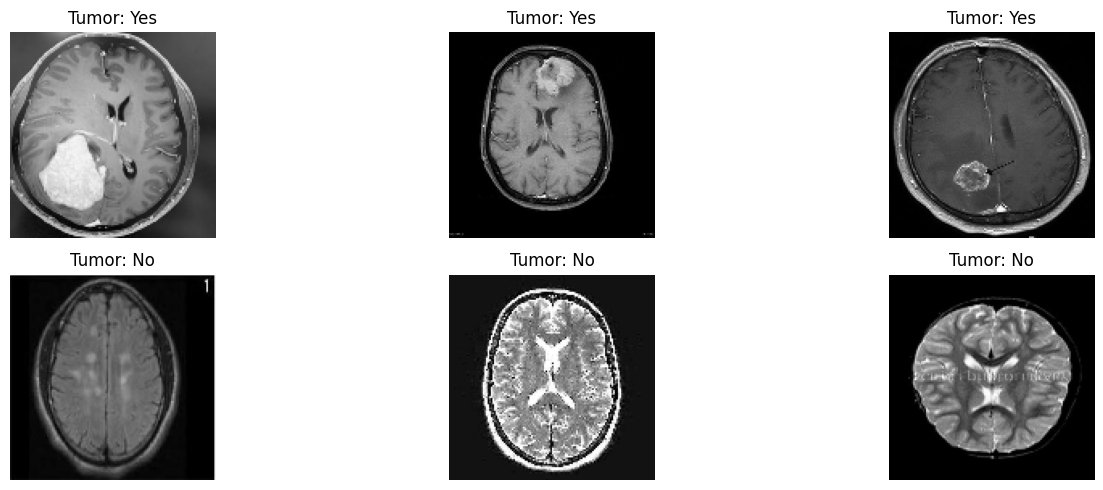

In [ ]:
plt.figure(figsize=(15, 5))

# Display tumor images with label 'yes'
for i in range(3):
    plt.subplot(2, 3, i+1)
    plt.imshow(tumor[i][0])
    plt.title("Tumor: Yes")
    plt.axis('off')

# Display no_tumor images with label 'no'
for i in range(3):
    plt.subplot(2, 3, i+4)
    plt.imshow(no_tumor[i][0])
    plt.title("Tumor: No")
    plt.axis('off')

plt.tight_layout()
plt.show()

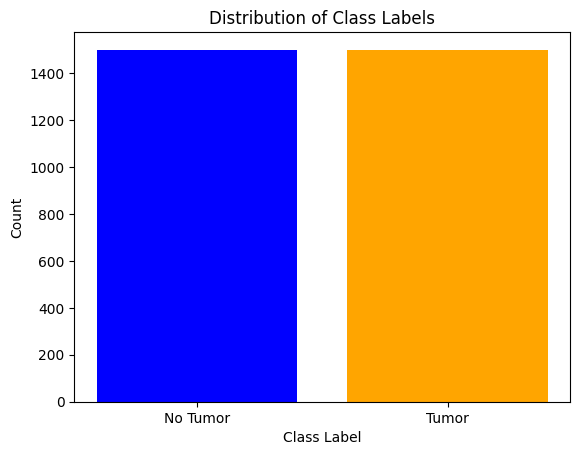

In [ ]:
unique_labels, label_counts = np.unique(labels, return_counts=True)

plt.bar(unique_labels, label_counts, color=['blue', 'orange'])
plt.xticks(unique_labels, ['No Tumor', 'Tumor'])
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Distribution of Class Labels')
plt.show()

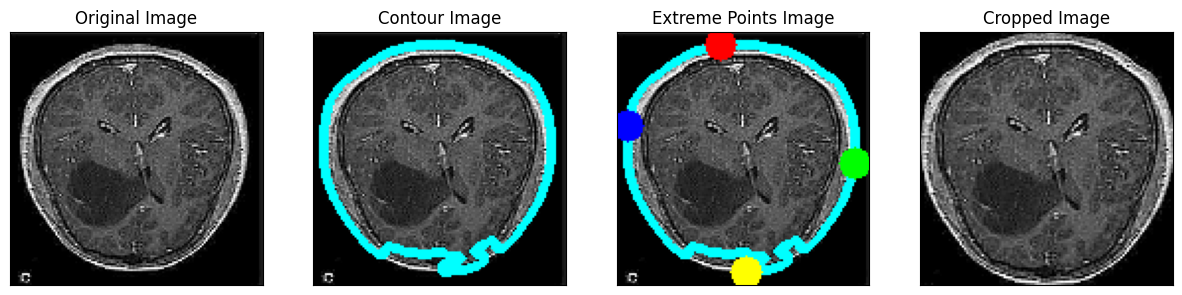

In [ ]:
import imutils
# Assuming you have defined IMG_SIZE elsewhere
IMG_SIZE = (128, 128)

# Load the image
img = cv2.imread('/content/drive/MyDrive/DL_Project/Tumor_Dataset/yes/y982.jpg')

# Resize the image
img = cv2.resize(img, dsize=IMG_SIZE, interpolation=cv2.INTER_CUBIC)

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur
gray_blur = cv2.GaussianBlur(gray, (5, 5), 0)

# Thresholding
thresh = cv2.threshold(gray_blur, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# Find contours
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# Find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# Add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# Add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# Crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

# Display the results
plt.figure(figsize=(15, 6))

# Step 1: Original Image
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Original Image')

# Step 2: Contour Image
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Contour Image')

# Step 3: Extreme Points Image
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Extreme Points Image')

# Step 4: Cropped Image
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Cropped Image')

plt.show()

In [ ]:
# Split data into training and test sets
x_train_val, x_test, y_train_val, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Split training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Data scaling
x_train_scaled = x_train / 255
x_val_scaled = x_val / 255
x_test_scaled = x_test / 255

**EfficientNetB7 Model**

In [ ]:
train_datagen=ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

base_model_efficientnet=EfficientNetB7(include_top=False,weights='imagenet',input_shape=(128, 128, 3),pooling='max')

for layer in base_model_efficientnet.layers:
    layer.trainable=False

model_efficientnet=Sequential([
    base_model_efficientnet,
    Dense(128, activation='relu',kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(64, activation='relu',kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

opt_efficientnet=Adam()
model_efficientnet.compile(optimizer=opt_efficientnet,loss='binary_crossentropy',metrics=['accuracy'])

early_stopping=EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)

train_generator=train_datagen.flow(x_train,y_train,batch_size=512)

history_efficientnet=model_efficientnet.fit(train_generator,epochs=100,validation_data=(x_val, y_val),callbacks=[early_stopping])


Epoch 1/100
4/4 [==============================] - 46s 6s/step - loss: 3.9407 - accuracy: 0.6144 - val_loss: 3.5778 - val_accuracy: 0.7500
Epoch 2/100
4/4 [==============================] - 13s 4s/step - loss: 3.5402 - accuracy: 0.6794 - val_loss: 3.2803 - val_accuracy: 0.7783
Epoch 3/100
4/4 [==============================] - 14s 3s/step - loss: 3.2314 - accuracy: 0.7306 - val_loss: 2.9662 - val_accuracy: 0.8117
Epoch 4/100
4/4 [==============================] - 14s 3s/step - loss: 2.9005 - accuracy: 0.7844 - val_loss: 2.7024 - val_accuracy: 0.8217
Epoch 5/100
4/4 [==============================] - 14s 4s/step - loss: 2.6330 - accuracy: 0.7939 - val_loss: 2.4646 - val_accuracy: 0.8333
Epoch 6/100
4/4 [==============================] - 14s 3s/step - loss: 2.3949 - accuracy: 0.8300 - val_loss: 2.2615 - val_accuracy: 0.8517
Epoch 7/100
4/4 [==============================] - 14s 4s/step - loss: 2.1898 - accuracy: 0.8367 - val_loss: 2.0450 - val_accuracy: 0.8617
Epoch 8/100
4/4 [==========

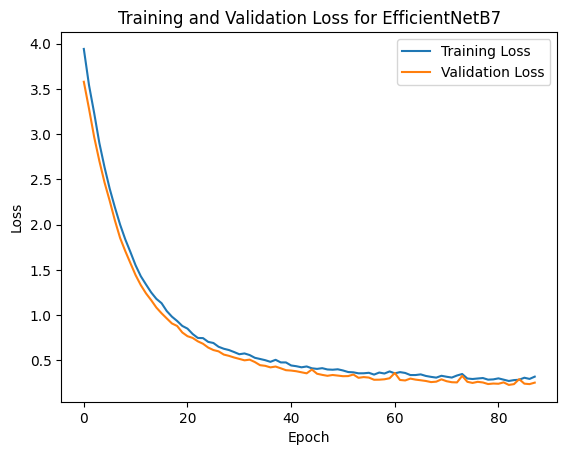

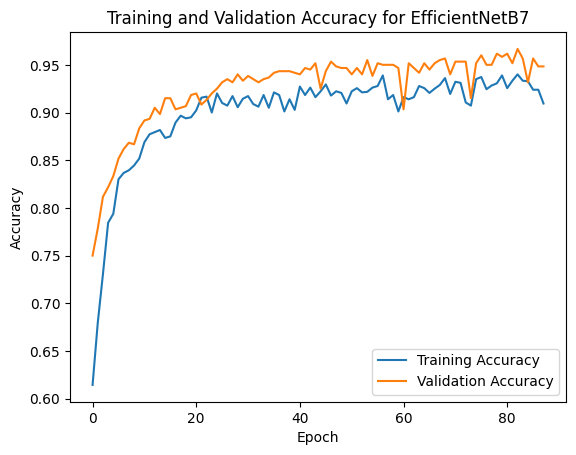

In [ ]:
# Access training history
train_loss = history_efficientnet.history['loss']
val_loss = history_efficientnet.history['val_loss']
train_accuracy = history_efficientnet.history['accuracy']
val_accuracy = history_efficientnet.history['val_accuracy']

# Plot training and validation loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss for EfficientNetB7')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy for EfficientNetB7')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

19/19 [==============================] - 3s 137ms/step - loss: 0.2234 - accuracy: 0.9633


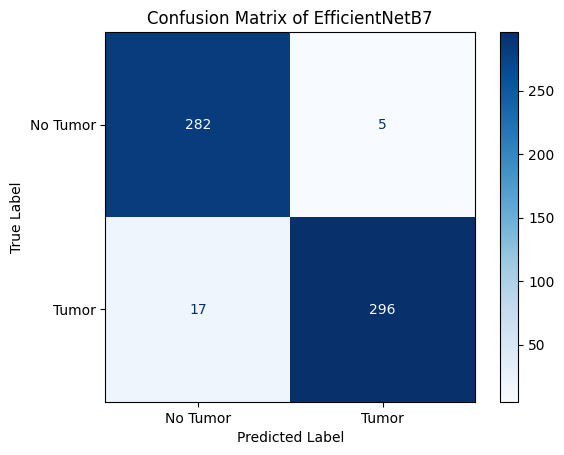

Accuracy of EfficientNetB7:  0.9633333333333334
Precision of EfficientNetB7:  0.9833887043189369
Recall of EfficientNetB7: 0.9456869009584664
Specificity of EfficientNetB7:  0.9825783972125436


In [ ]:
model_efficientnet_prediction=model_efficientnet.predict(x_test)
model_efficientnet_prediction=model_efficientnet_prediction.round()
model_efficientnet_test_ls,model_efficientnet_accuracy=model_efficientnet.evaluate(x_test,y_test)

efficientnet_confusion_matrix=confusion_matrix(y_test,model_efficientnet_prediction)
confusion_matrix_display = ConfusionMatrixDisplay(confusion_matrix=efficientnet_confusion_matrix, display_labels=["No Tumor", "Tumor"])
confusion_matrix_display.plot(cmap='Blues')
plt.title('Confusion Matrix of EfficientNetB7')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks()
plt.yticks()
plt.show()

efficientnet_accuracy=accuracy_score(y_test,model_efficientnet_prediction)
efficientnet_precision=precision_score(y_test,model_efficientnet_prediction)
efficientnet_recall=recall_score(y_test,model_efficientnet_prediction)
efficientnet_specificity=efficientnet_confusion_matrix[0][0]/(efficientnet_confusion_matrix[0][0]+efficientnet_confusion_matrix[0][1])

print("Accuracy of EfficientNetB7: ",efficientnet_accuracy)
print("Precision of EfficientNetB7: ",efficientnet_precision)
print("Recall of EfficientNetB7: {}".format(efficientnet_recall))
print("Specificity of EfficientNetB7: ",efficientnet_specificity)

In [ ]:
model_efficientnet.save('/content/drive/MyDrive/DL_Project/EfficientNet')

In [ ]:
effnt=tf.keras.models.load_model('/content/drive/MyDrive/DL_Project/EfficientNet')

In [ ]:
effnt.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional  (None, 2560)              64097687  
 )                                                               
                                                                 
 dense_9 (Dense)             (None, 128)               327808    
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                      

In [ ]:
model_efficientnet = load_model('/content/drive/MyDrive/DL_Project/EfficientNet')

19/19 [==============================] - 104s 5s/step


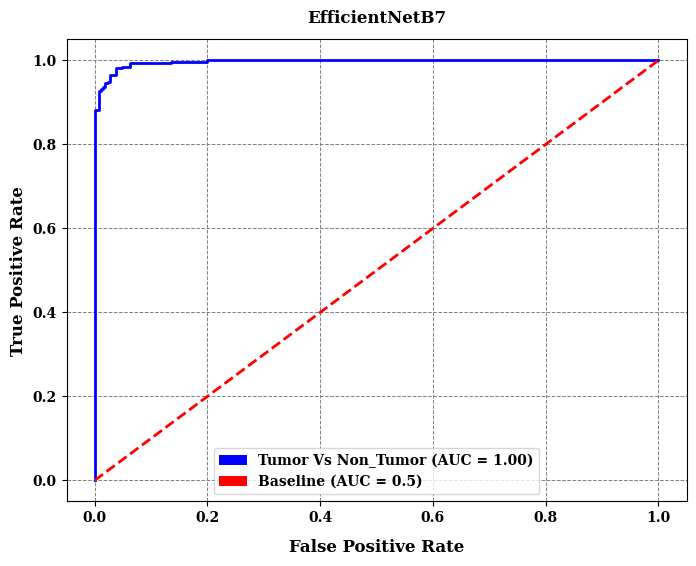

In [ ]:
y_pred_proba = model_efficientnet.predict(x_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

font = {'family': 'Serif', 'weight': 'bold', 'size': 12}

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Baseline')
plt.xlabel('False Positive Rate', fontdict=font)
plt.ylabel('True Positive Rate', fontdict=font)
plt.title('EfficientNetB7', fontdict=font, pad=12)

legend_handles = [
    Patch(facecolor='blue',  label='Tumor Vs Non_Tumor (AUC = %0.2f)' % roc_auc),
    Patch(facecolor='red',  label='Baseline (AUC = 0.5)')
]

plt.legend(handles=legend_handles, loc='lower center', ncol=1, prop={'family': 'Serif', 'weight': 'bold', 'size': 10})
plt.grid(True, linestyle='--', linewidth=0.7, color='gray')
plt.xticks(fontname='Serif', weight='bold')
plt.yticks(fontname='Serif', weight='bold')
plt.gca().xaxis.labelpad = 10
plt.show()

**ResNet152 Model**

In [ ]:
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Load ResNet152 model
base_model = ResNet152(include_top=False, weights='imagenet', input_shape=(128, 128, 3), pooling='max')

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Build the model
model_resnet = Sequential([
    base_model,
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.6),
    Dense(1, activation='sigmoid')
])

# Compile the model
opt = Adam(lr=0.001)
model_resnet.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Data Augmentation for training data
train_generator = train_datagen.flow(x_train, y_train, batch_size=32)

# Train the model
history = model_resnet.fit(train_generator,
                           epochs=50,
                           validation_data=(x_val, y_val),
                           callbacks=[early_stopping])


Epoch 1/50
75/75 [==============================] - 32s 285ms/step - loss: 1.1792 - accuracy: 0.7729 - val_loss: 0.4575 - val_accuracy: 0.9067
Epoch 2/50
75/75 [==============================] - 18s 242ms/step - loss: 0.5189 - accuracy: 0.8646 - val_loss: 0.4124 - val_accuracy: 0.9000
Epoch 3/50
75/75 [==============================] - 16s 216ms/step - loss: 0.4771 - accuracy: 0.8729 - val_loss: 0.3404 - val_accuracy: 0.9467
Epoch 4/50
75/75 [==============================] - 25s 338ms/step - loss: 0.4249 - accuracy: 0.8954 - val_loss: 0.3179 - val_accuracy: 0.9333
Epoch 5/50
75/75 [==============================] - 18s 236ms/step - loss: 0.4034 - accuracy: 0.8988 - val_loss: 0.2925 - val_accuracy: 0.9500
Epoch 6/50
75/75 [==============================] - 19s 254ms/step - loss: 0.3832 - accuracy: 0.9108 - val_loss: 0.2896 - val_accuracy: 0.9583
Epoch 7/50
75/75 [==============================] - 26s 351ms/step - loss: 0.3603 - accuracy: 0.9175 - val_loss: 0.2834 - val_accuracy: 0.9500

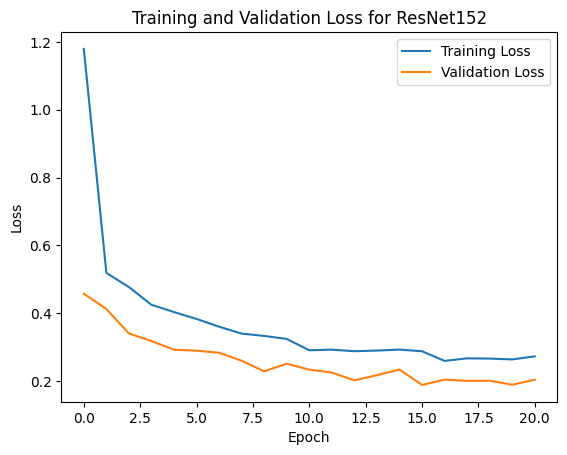

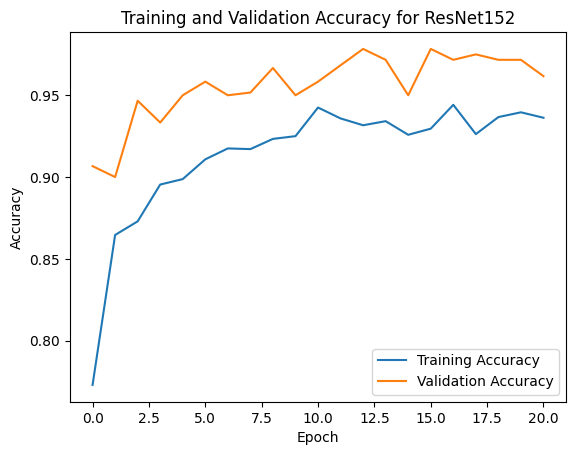

In [ ]:
# Access training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot training and validation loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss for ResNet152')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy for ResNet152')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

19/19 [==============================] - 2s 82ms/step - loss: 0.1887 - accuracy: 0.9783


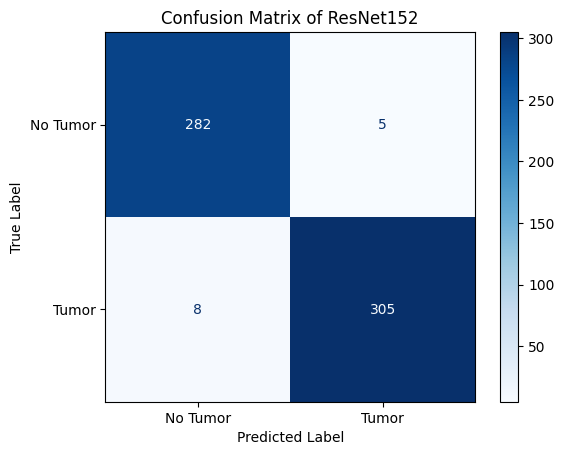

Accuracy of ResNet152:  0.9783333333333334
Precision of ResNet152:  0.9838709677419355
Recall of ResNet152: 0.9744408945686901
Specificity of ResNet152:  0.9825783972125436


In [ ]:
model_resnet_prediction=model_resnet.predict(x_test)
model_resnet_prediction=model_resnet_prediction.round()
model_resnet_test_ls, model_resnet_accuracy = model_resnet.evaluate(x_test,y_test)

resnet_confusion_matrix=confusion_matrix(y_test,model_resnet_prediction)
confusion_matrix_display = ConfusionMatrixDisplay(confusion_matrix=resnet_confusion_matrix, display_labels=["No Tumor", "Tumor"])
confusion_matrix_display.plot(cmap='Blues')
plt.title('Confusion Matrix of ResNet152')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks()
plt.yticks()
plt.show()

resnet_accuracy=accuracy_score(y_test,model_resnet_prediction)
resnet_precision=precision_score(y_test,model_resnet_prediction)
resnet_recall=recall_score(y_test,model_resnet_prediction)
resnet_specificity=resnet_confusion_matrix[0][0]/(resnet_confusion_matrix[0][0] + resnet_confusion_matrix[0][1])

print("Accuracy of ResNet152: ",resnet_accuracy)
print("Precision of ResNet152: ",resnet_precision)
print("Recall of ResNet152: {}".format(resnet_recall))
print("Specificity of ResNet152: ",resnet_specificity)

In [ ]:
model_resnet.save('/content/drive/MyDrive/DL_Project/ResNet')

In [ ]:
model_resnet.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152 (Functional)      (None, 2048)              58370944  
                                                                 
 dense_16 (Dense)            (None, 128)               262272    
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_17 (Dense)            (None, 1)                 129       
                                                                 
Total params: 58633345 (223.67 MB)
Trainable params: 262401 (1.00 MB)
Non-trainable params: 58370944 (222.67 MB)
_________________________________________________________________


In [ ]:
model_resnet = load_model('/content/drive/MyDrive/DL_Project/ResNet')

19/19 [==============================] - 89s 4s/step


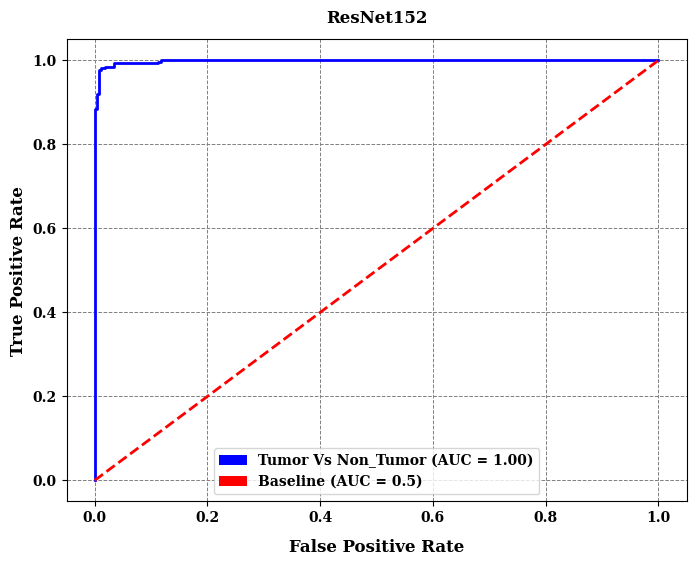

In [ ]:
y_pred_proba = model_resnet.predict(x_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

font = {'family': 'Serif', 'weight': 'bold', 'size': 12}

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Baseline')
plt.xlabel('False Positive Rate', fontdict=font)
plt.ylabel('True Positive Rate', fontdict=font)
plt.title('ResNet152', fontdict=font, pad=12)

legend_handles = [
    Patch(facecolor='blue',  label='Tumor Vs Non_Tumor (AUC = %0.2f)' % roc_auc),
    Patch(facecolor='red',  label='Baseline (AUC = 0.5)')
]

plt.legend(handles=legend_handles, loc='lower center', ncol=1, prop={'family': 'Serif', 'weight': 'bold', 'size': 10})
plt.grid(True, linestyle='--', linewidth=0.7, color='gray')
plt.xticks(fontname='Serif', weight='bold')
plt.yticks(fontname='Serif', weight='bold')
plt.gca().xaxis.labelpad = 10
plt.show()

### Visualization using VGG16

1/1 [==============================] - 0s 157ms/step


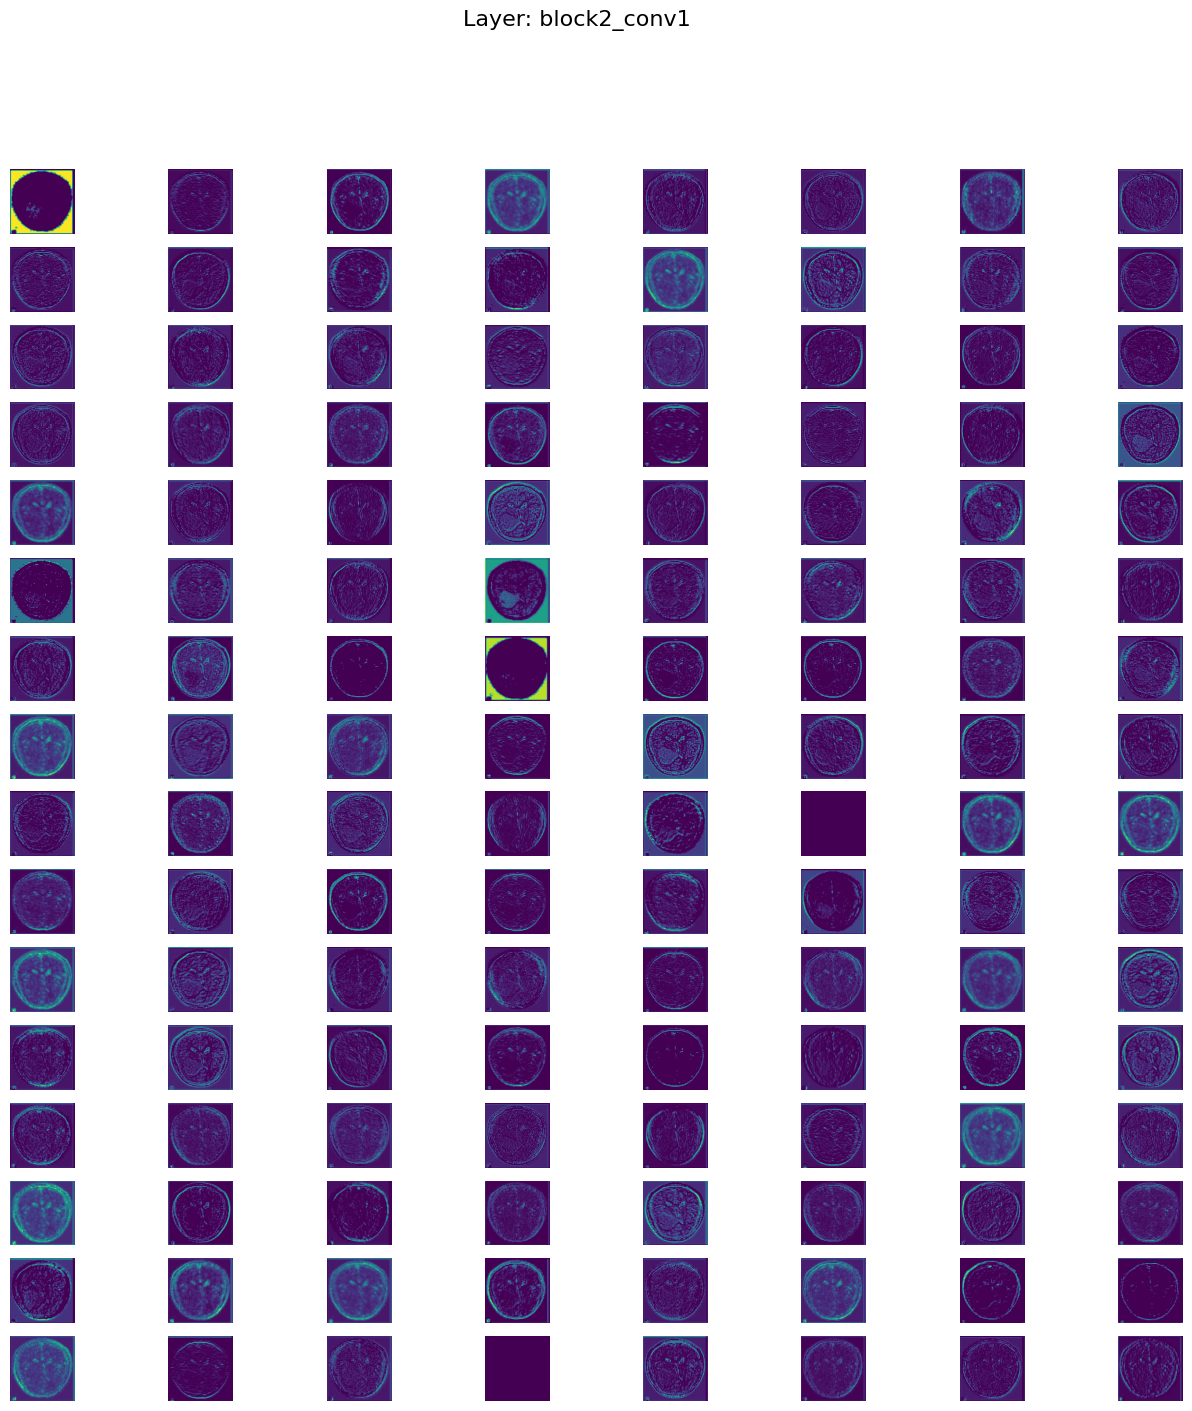

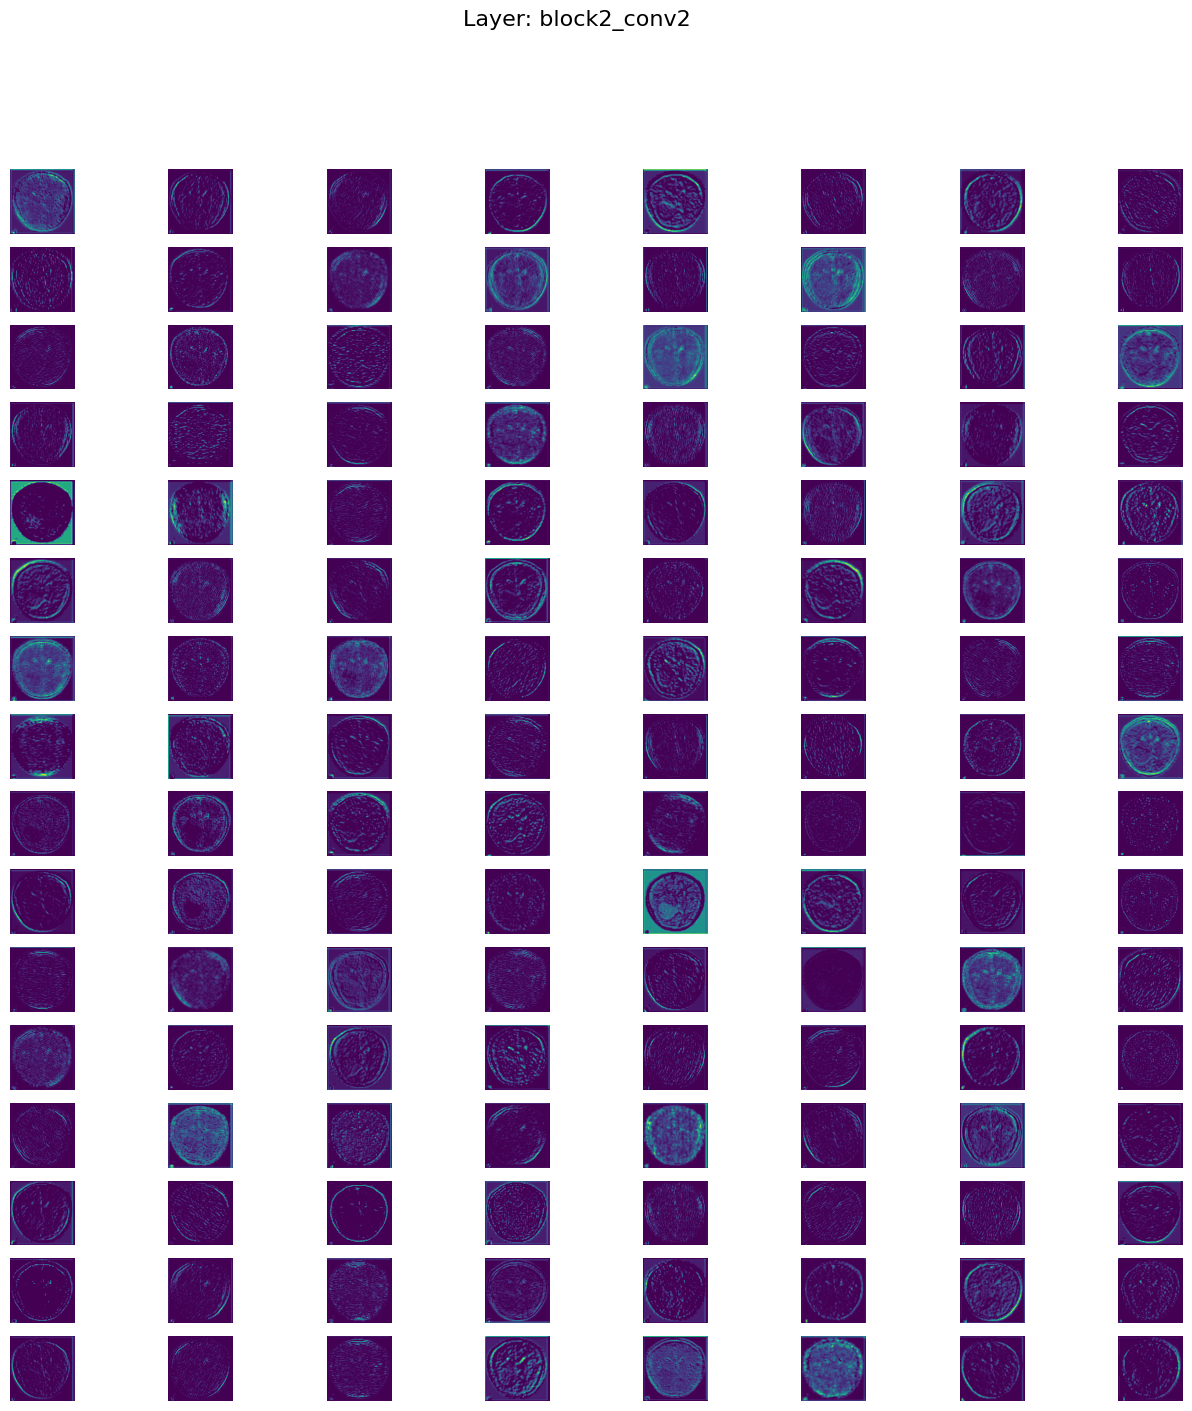

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
from keras.models import Model

# Load the pre-trained VGG16 model
model_vgg = VGG16(weights='imagenet', include_top=True)

# Get the desired convolutional layers by name
layer_names = ['block2_conv1', 'block2_conv2']
conv_layers = [model_vgg.get_layer(name).output for name in layer_names]

# Create a new model that outputs the activations of the selected convolutional layers
activation_model = Model(inputs=model_vgg.input, outputs=conv_layers)

# Load and preprocess the image
img_path = '/content/drive/MyDrive/DL_Project/Tumor_Dataset/yes/y982.jpg'
img = image.load_img(img_path, target_size=(224, 224))  # VGG16 requires input size (224, 224)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Get the activations
activations = activation_model.predict(x)

# Plot the feature maps for each selected convolutional layer
for layer_activation, layer_name in zip(activations, layer_names):
    num_filters = layer_activation.shape[-1]
    plt.figure(figsize=(16, 16))
    for i in range(num_filters):
        plt.subplot(num_filters // 8, 8, i + 1)  # Adjust subplot grid as needed
        plt.imshow(layer_activation[0, :, :, i], cmap='viridis')
        plt.axis('off')
    plt.suptitle(f'Layer: {layer_name}', fontsize=16)
    plt.show()


**InceptionV3 Model**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Load InceptionV3 model
base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(128, 128, 3), pooling = 'max')

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Build the model
model_inception = Sequential([
    base_model,
    #Dense(256, activation='relu'),
    #Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.1),
    #Dense(64, activation='relu'),
    #Dropout(0.1),
    Dense(1, activation='sigmoid')
])

# Compile the model
opt = Adam()
model_inception.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Data Augmentation for training data
train_generator = train_datagen.flow(x_train, y_train, batch_size=32)

# Train the model
history_inc = model_inception.fit(train_generator,
                              epochs=100,
                              validation_data=(x_val, y_val),
                              callbacks=[early_stopping])

Epoch 1/100
57/57 [==============================] - 15s 193ms/step - loss: 10.1615 - accuracy: 0.6539 - val_loss: 0.8526 - val_accuracy: 0.7683
Epoch 2/100
57/57 [==============================] - 10s 169ms/step - loss: 0.7193 - accuracy: 0.6978 - val_loss: 0.5803 - val_accuracy: 0.6833
Epoch 3/100
57/57 [==============================] - 10s 169ms/step - loss: 0.5653 - accuracy: 0.7189 - val_loss: 0.5450 - val_accuracy: 0.7200
Epoch 4/100
57/57 [==============================] - 10s 170ms/step - loss: 0.5469 - accuracy: 0.7300 - val_loss: 0.5248 - val_accuracy: 0.6917
Epoch 5/100
57/57 [==============================] - 10s 170ms/step - loss: 0.5532 - accuracy: 0.7239 - val_loss: 0.5322 - val_accuracy: 0.7567
Epoch 6/100
57/57 [==============================] - 9s 166ms/step - loss: 0.5313 - accuracy: 0.7478 - val_loss: 0.6282 - val_accuracy: 0.7117
Epoch 7/100
57/57 [==============================] - 10s 167ms/step - loss: 0.4857 - accuracy: 0.7706 - val_loss: 0.4643 - val_accuracy:

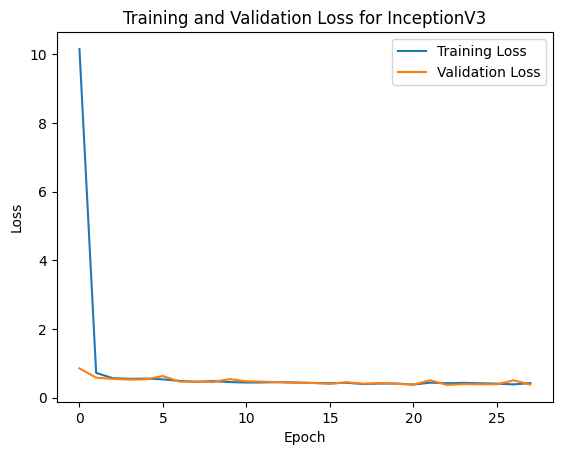

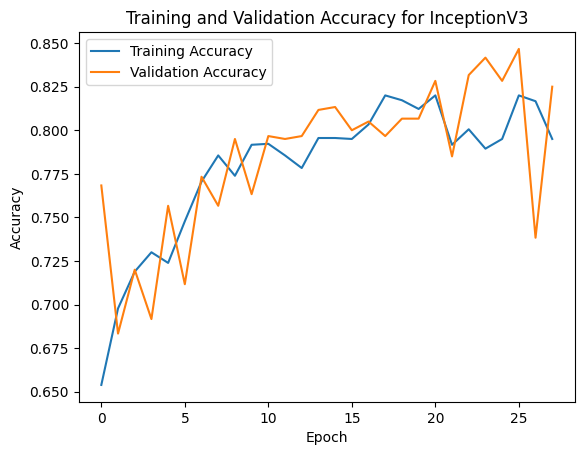

In [ ]:
# Access training history
train_loss = history_inc.history['loss']
val_loss = history_inc.history['val_loss']
train_accuracy = history_inc.history['accuracy']
val_accuracy = history_inc.history['val_accuracy']

# Plot training and validation loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss for InceptionV3')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy for InceptionV3')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

19/19 [==============================] - 2s 83ms/step - loss: 0.3579 - accuracy: 0.8533


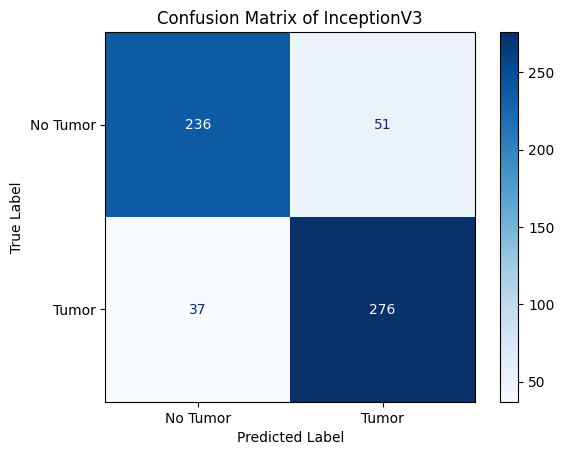

Accuracy of InceptionV3:  0.8533333333333334
Precision of InceptionV3:  0.8440366972477065
Recall of InceptionV3: 0.8817891373801917
Specificity of InceptionV3:  0.8222996515679443


In [ ]:
model_inception_prediction=model_inception.predict(x_test)
model_inception_prediction=model_inception_prediction.round()
model_inception_test_ls, model_inception_accuracy = model_inception.evaluate(x_test,y_test)

inception_confusion_matrix=confusion_matrix(y_test,model_inception_prediction)
confusion_matrix_display = ConfusionMatrixDisplay(confusion_matrix=inception_confusion_matrix, display_labels=["No Tumor", "Tumor"])
confusion_matrix_display.plot(cmap='Blues')
plt.title('Confusion Matrix of InceptionV3')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks()
plt.yticks()
plt.show()

inception_accuracy=accuracy_score(y_test,model_inception_prediction)
inception_precision=precision_score(y_test,model_inception_prediction)
inception_recall=recall_score(y_test,model_inception_prediction)
inception_specificity=inception_confusion_matrix[0][0]/(inception_confusion_matrix[0][0] + inception_confusion_matrix[0][1])

print("Accuracy of InceptionV3: ",inception_accuracy)
print("Precision of InceptionV3: ",inception_precision)
print("Recall of InceptionV3: {}".format(inception_recall))
print("Specificity of InceptionV3: ",inception_specificity)

In [ ]:
model_inception.save('/content/drive/MyDrive/DL_Project/Inception')

In [ ]:
model_inception.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 dense_6 (Dense)             (None, 128)               262272    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 22065185 (84.17 MB)
Trainable params: 262401 (1.00 MB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


In [ ]:
model_inception = load_model('/content/drive/MyDrive/DL_Project/Inception')

19/19 [==============================] - 18s 877ms/step


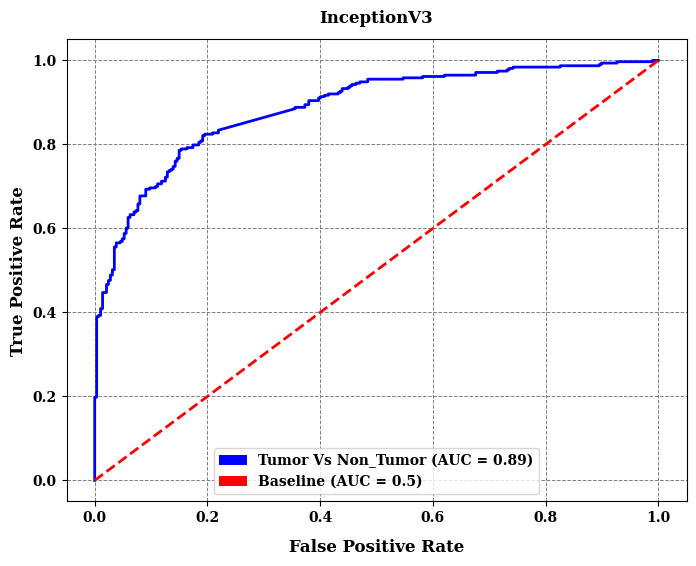

In [ ]:
y_pred_proba = model_inception.predict(x_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

font = {'family': 'Serif', 'weight': 'bold', 'size': 12}

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Baseline')
plt.xlabel('False Positive Rate', fontdict=font)
plt.ylabel('True Positive Rate', fontdict=font)
plt.title('InceptionV3', fontdict=font, pad=12)

legend_handles = [
    Patch(facecolor='blue',  label='Tumor Vs Non_Tumor (AUC = %0.2f)' % roc_auc),
    Patch(facecolor='red',  label='Baseline (AUC = 0.5)')
]

plt.legend(handles=legend_handles, loc='lower center', ncol=1, prop={'family': 'Serif', 'weight': 'bold', 'size': 10})
plt.grid(True, linestyle='--', linewidth=0.7, color='gray')
plt.xticks(fontname='Serif', weight='bold')
plt.yticks(fontname='Serif', weight='bold')
plt.gca().xaxis.labelpad = 10
plt.show()

**InceptionResNetV2**

In [ ]:
train_datagen=ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

base_model_inceptionresnet=InceptionResNetV2(include_top=False,weights='imagenet',input_shape=(128, 128, 3),pooling='max')

for layer in base_model_inceptionresnet.layers:
    layer.trainable=False

model_inceptionresnet=Sequential([
    base_model_inceptionresnet,
    Dense(128, activation='relu',kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(64, activation='relu',kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

opt_inceptionresnet=Adam()
model_inceptionresnet.compile(optimizer=opt_inceptionresnet,loss='binary_crossentropy',metrics=['accuracy'])

early_stopping=EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)

train_generator=train_datagen.flow(x_train,y_train,batch_size=32)

history_inceptionresnet=model_inceptionresnet.fit(train_generator,epochs=100,validation_data=(x_val, y_val),callbacks=[early_stopping])


219055592/219055592 [==============================] - 1s 0us/step
Epoch 1/100
57/57 [==============================] - 32s 393ms/step - loss: 31.8916 - accuracy: 0.4850 - val_loss: 2.5143 - val_accuracy: 0.4883
Epoch 2/100
57/57 [==============================] - 19s 329ms/step - loss: 3.1693 - accuracy: 0.5100 - val_loss: 2.3959 - val_accuracy: 0.4883
Epoch 3/100
57/57 [==============================] - 19s 329ms/step - loss: 2.7562 - accuracy: 0.5178 - val_loss: 2.3459 - val_accuracy: 0.4883
Epoch 4/100
57/57 [==============================] - 19s 327ms/step - loss: 2.3189 - accuracy: 0.5111 - val_loss: 2.2959 - val_accuracy: 0.4883
Epoch 5/100
57/57 [==============================] - 19s 326ms/step - loss: 2.2743 - accuracy: 0.5111 - val_loss: 2.2555 - val_accuracy: 0.4883
Epoch 6/100
57/57 [==============================] - 19s 325ms/step - loss: 2.2362 - accuracy: 0.5111 - val_loss: 2.2189 - val_accuracy: 0.4883
Epoch 7/100
57/57 [==============================] - 19s 325ms/step 

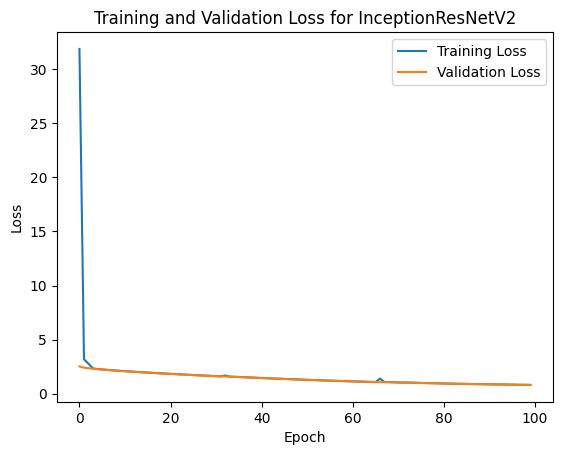

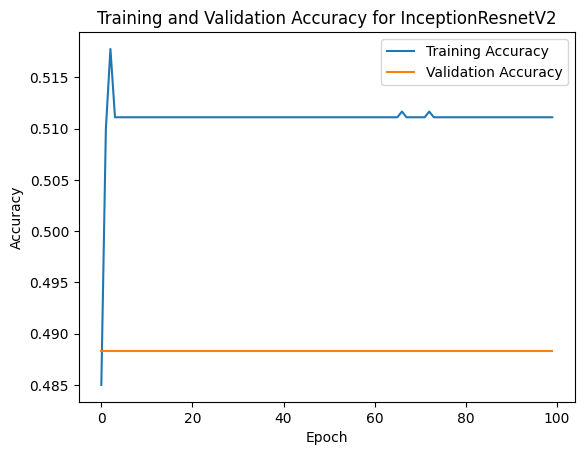

In [ ]:
# Access training history
train_loss = history_inceptionresnet.history['loss']
val_loss = history_inceptionresnet.history['val_loss']
train_accuracy = history_inceptionresnet.history['accuracy']
val_accuracy = history_inceptionresnet.history['val_accuracy']

# Plot training and validation loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss for InceptionResNetV2')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy for InceptionResnetV2')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

19/19 [==============================] - 4s 235ms/step - loss: 0.8017 - accuracy: 0.4783


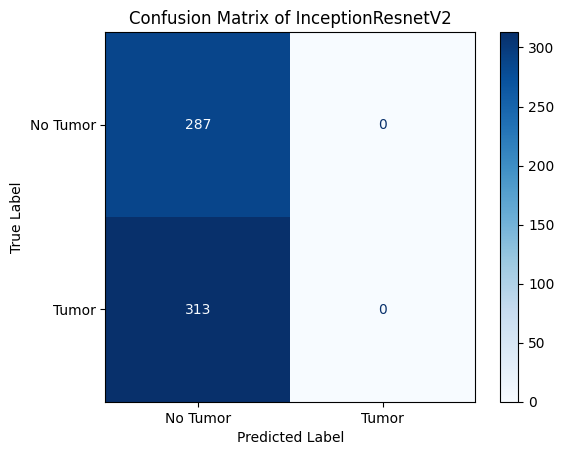

Accuracy of InceptionResNetV2:  0.47833333333333333
Precision of InceptionResNetV2:  0.0
Recall of InceptionResNetV2: 0.0
Specificity of InceptionResNetV2:  1.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model_inceptionresnet_prediction=model_inceptionresnet.predict(x_test)
model_inceptionresnet_prediction=model_inceptionresnet_prediction.round()
model_inceptionresnet_test_ls, model_inceptionresnet_accuracy = model_inceptionresnet.evaluate(x_test,y_test)

inceptionresnet_confusion_matrix=confusion_matrix(y_test,model_inceptionresnet_prediction)
confusion_matrix_display = ConfusionMatrixDisplay(confusion_matrix=inceptionresnet_confusion_matrix, display_labels=["No Tumor", "Tumor"])
confusion_matrix_display.plot(cmap='Blues')
plt.title('Confusion Matrix of InceptionResnetV2')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks()
plt.yticks()
plt.show()

inceptionresnet_accuracy=accuracy_score(y_test,model_inceptionresnet_prediction)
inceptionresnet_precision=precision_score(y_test,model_inceptionresnet_prediction)
inceptionresnet_recall=recall_score(y_test,model_inceptionresnet_prediction)
inceptionresnet_specificity=inceptionresnet_confusion_matrix[0][0]/(inceptionresnet_confusion_matrix[0][0] + inceptionresnet_confusion_matrix[0][1])

print("Accuracy of InceptionResNetV2: ",inceptionresnet_accuracy)
print("Precision of InceptionResNetV2: ",inceptionresnet_precision)
print("Recall of InceptionResNetV2: {}".format(inceptionresnet_recall))
print("Specificity of InceptionResNetV2: ",inceptionresnet_specificity)

19/19 [==============================] - 5s 237ms/step


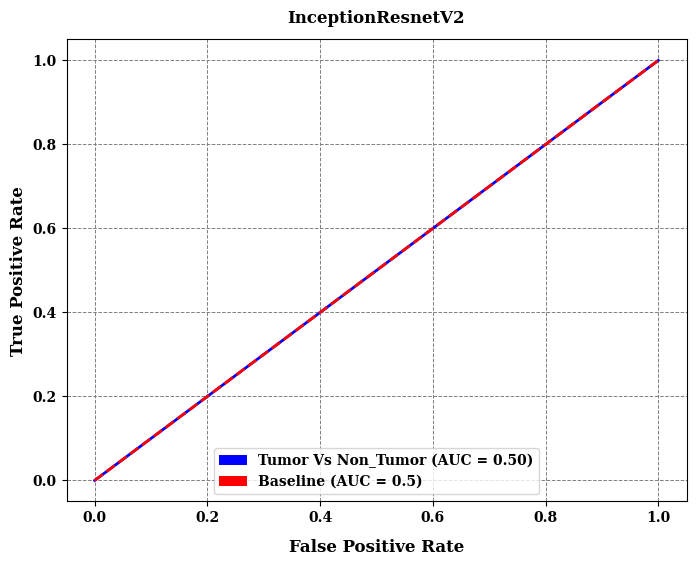

In [ ]:
y_pred_proba = model_inceptionresnet.predict(x_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

font = {'family': 'Serif', 'weight': 'bold', 'size': 12}

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Baseline')
plt.xlabel('False Positive Rate', fontdict=font)
plt.ylabel('True Positive Rate', fontdict=font)
plt.title('InceptionResnetV2', fontdict=font, pad=12)

legend_handles = [
    Patch(facecolor='blue',  label='Tumor Vs Non_Tumor (AUC = %0.2f)' % roc_auc),
    Patch(facecolor='red',  label='Baseline (AUC = 0.5)')
]

plt.legend(handles=legend_handles, loc='lower center', ncol=1, prop={'family': 'Serif', 'weight': 'bold', 'size': 10})
plt.grid(True, linestyle='--', linewidth=0.7, color='gray')
plt.xticks(fontname='Serif', weight='bold')
plt.yticks(fontname='Serif', weight='bold')
plt.gca().xaxis.labelpad = 10
plt.show()

**Optimized InceptionResNetV2 Model**

In [ ]:
train_datagen=ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

base_model_inceptionresnet=InceptionResNetV2(include_top=False,weights='imagenet',input_shape=(128, 128, 3),pooling='max')

for layer in base_model_inceptionresnet.layers[-10:]:
    layer.trainable=True

model_inceptionresnet=Sequential([
    base_model_inceptionresnet,
    Dense(128, activation='relu',kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(64, activation='relu',kernel_regularizer=l2(0.01)),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

opt_inceptionresnet=Adam(learning_rate=0.001)
model_inceptionresnet.compile(optimizer=opt_inceptionresnet,loss='binary_crossentropy',metrics=['accuracy'])

early_stopping=EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
reduce_lr=ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

train_generator=train_datagen.flow(x_train,y_train,batch_size=32)

history_inceptionresnet=model_inceptionresnet.fit(train_generator,epochs=100,validation_data=(x_val, y_val),callbacks=[early_stopping,reduce_lr])


Epoch 1/100
57/57 [==============================] - 109s 1s/step - loss: 2.9111 - accuracy: 0.8578 - val_loss: 3.3367 - val_accuracy: 0.5517 - lr: 0.0010
Epoch 2/100
57/57 [==============================] - 57s 1s/step - loss: 1.5260 - accuracy: 0.9206 - val_loss: 1.5357 - val_accuracy: 0.7750 - lr: 0.0010
Epoch 3/100
57/57 [==============================] - 56s 986ms/step - loss: 0.9395 - accuracy: 0.9483 - val_loss: 1.1881 - val_accuracy: 0.8217 - lr: 0.0010
Epoch 4/100
57/57 [==============================] - 55s 971ms/step - loss: 0.6537 - accuracy: 0.9456 - val_loss: 0.4744 - val_accuracy: 0.9817 - lr: 0.0010
Epoch 5/100
57/57 [==============================] - 55s 968ms/step - loss: 0.4481 - accuracy: 0.9600 - val_loss: 0.8963 - val_accuracy: 0.9283 - lr: 0.0010
Epoch 6/100
57/57 [==============================] - 55s 964ms/step - loss: 0.3532 - accuracy: 0.9633 - val_loss: 0.2865 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 7/100
57/57 [==============================] - 55s 964ms/

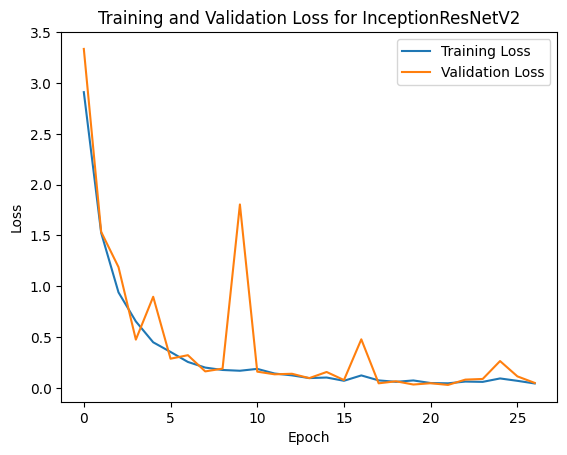

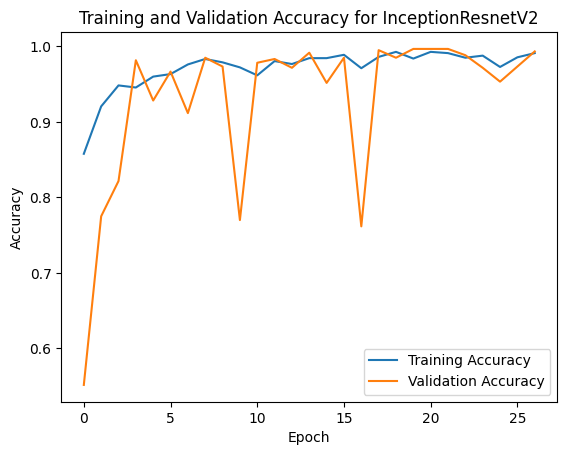

In [ ]:
# Access training history
train_loss = history_inceptionresnet.history['loss']
val_loss = history_inceptionresnet.history['val_loss']
train_accuracy = history_inceptionresnet.history['accuracy']
val_accuracy = history_inceptionresnet.history['val_accuracy']

# Plot training and validation loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss for InceptionResNetV2')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy for InceptionResnetV2')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

19/19 [==============================] - 45s 2s/step - loss: 0.0360 - accuracy: 0.9950


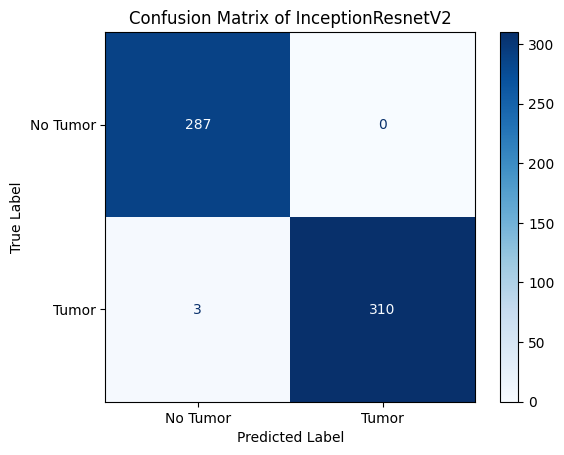

Accuracy of InceptionResNetV2:  0.995
Precision of InceptionResNetV2:  1.0
Recall of InceptionResNetV2: 0.9904153354632588
Specificity of InceptionResNetV2:  1.0


In [ ]:
model_inceptionresnet_prediction=model_inceptionresnet.predict(x_test)
model_inceptionresnet_prediction=model_inceptionresnet_prediction.round()
model_inceptionresnet_test_ls, model_inceptionresnet_accuracy = model_inceptionresnet.evaluate(x_test,y_test)

inceptionresnet_confusion_matrix=confusion_matrix(y_test,model_inceptionresnet_prediction)
confusion_matrix_display = ConfusionMatrixDisplay(confusion_matrix=inceptionresnet_confusion_matrix, display_labels=["No Tumor", "Tumor"])
confusion_matrix_display.plot(cmap='Blues')
plt.title('Confusion Matrix of InceptionResnetV2')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks()
plt.yticks()
plt.show()

inceptionresnet_accuracy=accuracy_score(y_test,model_inceptionresnet_prediction)
inceptionresnet_precision=precision_score(y_test,model_inceptionresnet_prediction)
inceptionresnet_recall=recall_score(y_test,model_inceptionresnet_prediction)
inceptionresnet_specificity=inceptionresnet_confusion_matrix[0][0]/(inceptionresnet_confusion_matrix[0][0] + inceptionresnet_confusion_matrix[0][1])

print("Accuracy of InceptionResNetV2: ",inceptionresnet_accuracy)
print("Precision of InceptionResNetV2: ",inceptionresnet_precision)
print("Recall of InceptionResNetV2: {}".format(inceptionresnet_recall))
print("Specificity of InceptionResNetV2: ",inceptionresnet_specificity)

In [ ]:
model_inceptionresnet.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Funct  (None, 1536)              54336736  
 ional)                                                          
                                                                 
 dense_54 (Dense)            (None, 128)               196736    
                                                                 
 dropout_23 (Dropout)        (None, 128)               0         
                                                                 
 dense_55 (Dense)            (None, 64)                8256      
                                                                 
 dropout_24 (Dropout)        (None, 64)                0         
                                                                 
 dense_56 (Dense)            (None, 1)                 65        
                                                     

In [ ]:
model_inceptionresnet.save('/content/drive/MyDrive/DL_Project/InceptionResNetv2')

In [ ]:
model_inceptionresnet = load_model('/content/drive/MyDrive/DL_Project/InceptionResNetv2')

19/19 [==============================] - 44s 2s/step


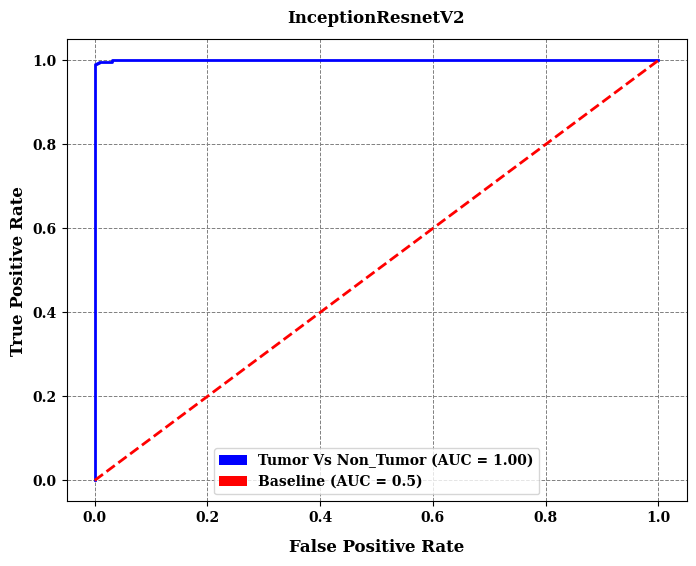

In [ ]:
y_pred_proba = model_inceptionresnet.predict(x_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

font = {'family': 'Serif', 'weight': 'bold', 'size': 12}

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Baseline')
plt.xlabel('False Positive Rate', fontdict=font)
plt.ylabel('True Positive Rate', fontdict=font)
plt.title('InceptionResnetV2', fontdict=font, pad=12)

legend_handles = [
    Patch(facecolor='blue',  label='Tumor Vs Non_Tumor (AUC = %0.2f)' % roc_auc),
    Patch(facecolor='red',  label='Baseline (AUC = 0.5)')
]

plt.legend(handles=legend_handles, loc='lower center', ncol=1, prop={'family': 'Serif', 'weight': 'bold', 'size': 10})
plt.grid(True, linestyle='--', linewidth=0.7, color='gray')
plt.xticks(fontname='Serif', weight='bold')
plt.yticks(fontname='Serif', weight='bold')
plt.gca().xaxis.labelpad = 10
plt.show()